In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [11]:
# ==========================================
# 1. PREPROCESSING & FILTERING FUNCTIONS
# ==========================================
def load_and_filter_data(filepath, date_col, target_col):
    # Load Data (header=1 uses the 2nd row as column names)
    try:
        df = pd.read_csv(filepath, header=1)
    except FileNotFoundError:
        # Create dummy data if file doesn't exist for demonstration
        print("CSV not found. Generating dummy data for demonstration...")
        dates = pd.date_range(start='2023-01-01', periods=2000, freq='H')
        df = pd.DataFrame({
            'Time (LST)': dates,
            '20" Soil Temp (°F)': np.sin(np.linspace(0, 100, 2000)) * 10 + 50 + np.random.normal(0, 1, 2000),
            'Air Temp': np.sin(np.linspace(0, 100, 2000)) * 15 + 60 + np.random.normal(0, 2, 2000),
            'Rain': np.random.choice([0, 1], size=2000, p=[0.9, 0.1])
        })
        filepath = 'dummy' # Override to skip logic

    # Clean whitespace in headers
    df.columns = df.columns.str.strip()

    # --- FIX: Handle Commas in Numbers (e.g., "1,066.5") ---
    df = df.replace(',', '', regex=True)
    
    for col in df.columns:
        if col != date_col:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if target_col not in df.columns:
        raise ValueError(f"Target '{target_col}' not found in CSV.")

    # --- FILTERING LOGIC ---
    cols_to_keep = []
    for col in df.columns:
        if col == date_col or col == target_col:
            cols_to_keep.append(col)
        elif "Soil" in col:
            continue 
        else:
            cols_to_keep.append(col)
            
    df_filtered = df[cols_to_keep].copy()
    
    # Parse Dates & Sort
    df_filtered[date_col] = pd.to_datetime(df_filtered[date_col])
    df_filtered = df_filtered.set_index(date_col).sort_index()
    
    # Data Cleaning
    limit = len(df_filtered) * 0.4
    df_filtered = df_filtered.dropna(axis=1, thresh=limit)
    df_filtered = df_filtered.interpolate(method='time')
    df_filtered = df_filtered.ffill().bfill()
    df_final = df_filtered.dropna()

    print(f"--- Final Data Shape: {df_final.shape} ---")
    return df_final

def create_sequences(data, seq_length, forecast_horizon, target_idx):
    """
    Creates Input (X) and Output (y) sequences.
    X: History of length 'seq_length'
    y: Future of length 'forecast_horizon'
    """
    xs, ys = [], []
    # Loop needs to stop early enough to have 24 hours of data ahead
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        x = data[i:(i + seq_length)]
        # Grab the next 24 hours as the target
        y = data[(i + seq_length):(i + seq_length + forecast_horizon), target_idx] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [12]:
# ==========================================
# 1. PREPROCESSING & FILTERING FUNCTIONS
# ==========================================
def load_and_filter_data(filepath, date_col, target_col):
    # Load Data (header=1 uses the 2nd row as column names)
    try:
        df = pd.read_csv(filepath, header=1)
    except FileNotFoundError:
        # Create dummy data if file doesn't exist for demonstration
        print("CSV not found. Generating dummy data for demonstration...")
        dates = pd.date_range(start='2023-01-01', periods=2000, freq='H')
        df = pd.DataFrame({
            'Time (LST)': dates,
            '20" Soil Temp (°F)': np.sin(np.linspace(0, 100, 2000)) * 10 + 50 + np.random.normal(0, 1, 2000),
            'Air Temp': np.sin(np.linspace(0, 100, 2000)) * 15 + 60 + np.random.normal(0, 2, 2000),
            'Rain': np.random.choice([0, 1], size=2000, p=[0.9, 0.1])
        })
        filepath = 'dummy' # Override to skip logic

    # Clean whitespace in headers
    df.columns = df.columns.str.strip()

    # --- FIX: Handle Commas in Numbers (e.g., "1,066.5") ---
    df = df.replace(',', '', regex=True)
    
    for col in df.columns:
        if col != date_col:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if target_col not in df.columns:
        raise ValueError(f"Target '{target_col}' not found in CSV.")

    # --- FILTERING LOGIC ---
    cols_to_keep = []
    for col in df.columns:
        if col == date_col or col == target_col:
            cols_to_keep.append(col)
        elif "Soil" in col:
            continue 
        else:
            cols_to_keep.append(col)
            
    df_filtered = df[cols_to_keep].copy()
    
    # Parse Dates & Sort
    df_filtered[date_col] = pd.to_datetime(df_filtered[date_col])
    df_filtered = df_filtered.set_index(date_col).sort_index()
    
    # Data Cleaning
    limit = len(df_filtered) * 0.4
    df_filtered = df_filtered.dropna(axis=1, thresh=limit)
    df_filtered = df_filtered.interpolate(method='time')
    df_filtered = df_filtered.ffill().bfill()
    df_final = df_filtered.dropna()

    print(f"--- Final Data Shape: {df_final.shape} ---")
    return df_final

def create_sequences(data, seq_length, forecast_horizon, target_idx):
    """
    Creates Input (X) and Output (y) sequences.
    X: History of length 'seq_length'
    y: Future of length 'forecast_horizon'
    """
    xs, ys = [], []
    # Loop needs to stop early enough to have 24 hours of data ahead
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        x = data[i:(i + seq_length)]
        # Grab the next 24 hours as the target
        y = data[(i + seq_length):(i + seq_length + forecast_horizon), target_idx] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [13]:
# ==========================================
# 2. MODEL DEFINITIONS
# ==========================================

# --- A. LSTM ---
class WeatherToSoilLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(WeatherToSoilLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

def train_lstm_model(train_X, train_y, test_X, input_dim, output_dim):
    train_data = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).float())
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    
    model = WeatherToSoilLSTM(input_dim=input_dim, hidden_dim=64, output_dim=output_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    print("\n--- Training LSTM (Multi-Step) ---")
    for epoch in range(15): 
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
    model.eval()
    with torch.no_grad():
        test_preds = model(torch.from_numpy(test_X).float()).numpy()
        
    return test_preds

# --- B. ICP (Invariant Causal Prediction) Proxy ---
class InvariantCausalRegressor:
    """
    Approximation of ICP for high-dimensional Time Series.
    """
    def __init__(self):
        self.mask = None
        self.model = LinearRegression()
        
    def fit(self, X, y):
        # 1. Define Environments (Split data in half)
        mid = len(X) // 2
        X_env1, y_env1 = X[:mid], y[:mid]
        X_env2, y_env2 = X[mid:], y[mid:]
        
        # 2. Train Selector Models (Lasso)
        y_env1_flat = y_env1[:, 0] 
        y_env2_flat = y_env2[:, 0]
        
        lasso1 = Lasso(alpha=0.001, random_state=42)
        lasso2 = Lasso(alpha=0.001, random_state=42)
        
        lasso1.fit(X_env1, y_env1_flat)
        lasso2.fit(X_env2, y_env2_flat)
        
        # 3. Find Invariant Set (Non-zero and Same Sign)
        coef1 = lasso1.coef_
        coef2 = lasso2.coef_
        
        significant = (np.abs(coef1) > 1e-4) & (np.abs(coef2) > 1e-4)
        same_sign = np.sign(coef1) == np.sign(coef2)
        self.mask = significant & same_sign
        
        num_features = np.sum(self.mask)
        print(f"   [ICP] Total Features: {X.shape[1]}. Invariant (Robust) Features found: {num_features}")
        
        if num_features == 0:
            print("   [ICP] Warning: No invariant features found. Reverting to all features.")
            self.mask[:] = True
            
        # 4. Train Final Model on masked data
        X_masked = X[:, self.mask]
        self.final_model = MultiOutputRegressor(LinearRegression())
        self.final_model.fit(X_masked, y)
        
    def predict(self, X):
        X_masked = X[:, self.mask]
        return self.final_model.predict(X_masked)

In [14]:
# ==========================================
# 3. DATA LOADING AND PREPARATION
# ==========================================
FILE_PATH = 'WholeYear.csv'           
DATE_COL = 'Time (LST)' 
TARGET_COL = '20" Soil Temp (°F)' 
SEQ_LENGTH = 48             # Look back 48 hours
FORECAST_HORIZON = 24       # Predict next 1 day

# 1. Load Data
df = load_and_filter_data(FILE_PATH, DATE_COL, TARGET_COL)

# 2. Scale Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.values)

target_idx = df.columns.get_loc(TARGET_COL)

# 3. Create Sequences
print(f"Generating sequences (Input: {SEQ_LENGTH}h -> Output: {FORECAST_HORIZON}h)...")
X, y = create_sequences(data_scaled, SEQ_LENGTH, FORECAST_HORIZON, target_idx)

if len(X) == 0:
    raise ValueError("Not enough data.")

# 4. Train/Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train Shape: {X_train.shape}, {y_train.shape}")
print(f"Test Shape:  {X_test.shape}, {y_test.shape}")

# --- FLATTEN INPUTS for Non-LSTM models ---
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

--- Final Data Shape: (5088, 14) ---
Generating sequences (Input: 48h -> Output: 24h)...
Train Shape: (4013, 48, 14), (4013, 24)
Test Shape:  (1004, 48, 14), (1004, 24)


In [27]:
# ==========================================
# 4. MODEL TRAINING
# ==========================================

# A. LSTM
lstm_preds_scaled = train_lstm_model(X_train, y_train, X_test, 
                               input_dim=X.shape[2], 
                               output_dim=FORECAST_HORIZON)

# B. Random Forest
print("\n--- Training Random Forest ---")
rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=42))
rf_model.fit(X_train_flat, y_train)
rf_preds_scaled = rf_model.predict(X_test_flat)

# C. Causal AR (Linear Baseline)
print("\n--- Training Causal AR (Linear) ---")
ar_model = MultiOutputRegressor(Ridge(alpha=1.0))
ar_model.fit(X_train_flat, y_train)
ar_preds_scaled = ar_model.predict(X_test_flat)

# D. ICP (Invariant Causal Prediction)
print("\n--- Training ICP (Invariant Causal Prediction) ---")
icp_model = InvariantCausalRegressor()
icp_model.fit(X_train_flat, y_train)
icp_preds_scaled = icp_model.predict(X_test_flat)




--- Training LSTM (Multi-Step) ---

--- Training Random Forest ---

--- Training Causal AR (Linear) ---

--- Training ICP (Invariant Causal Prediction) ---
   [ICP] Total Features: 672. Invariant (Robust) Features found: 6


In [31]:
# ==========================================
# 4.1 CAUSAL AR (RIDGE) INTERPRETATION
# ==========================================
import numpy as np
import pandas as pd

print("\n--- Causal AR Feature Interpretation ---")

# 1. Check if model exists
if 'ar_model' not in locals():
    print("Error: 'ar_model' not found. Please run the Model Training cell first.")
else:
    print(f"{'VARIABLE':<25} | {'LAG TIME':<10} | {'IMPORTANCE (Weight)':<20}")
    print("-" * 65)

    # 2. Extract Coefficients
    # ar_model.estimators_ is a list of models (one per forecast step, e.g., 24 hours)
    # We average the absolute weights across all future time steps to get general importance
    all_coefs = np.array([est.coef_ for est in ar_model.estimators_])
    mean_importance = np.mean(np.abs(all_coefs), axis=0) 

    # 3. Map flattened indices back to specific (Variable, Time Lag)
    # n_features and col_names should be available from the Data Prep cell
    n_features = df.shape[1]
    col_names = df.columns.tolist()
    
    feature_impacts = []

    for idx, weight in enumerate(mean_importance):
        # The input is flattened: [t-48 all features, t-47 all features, ...]
        feat_idx = idx % n_features
        time_step_idx = idx // n_features
        
        # Calculate Lag (e.g., Input sequence length is 48, so index 0 is t-48h)
        hours_ago = SEQ_LENGTH - time_step_idx
        
        feature_impacts.append({
            'name': col_names[feat_idx],
            'lag': f"t - {hours_ago}h",
            'weight': weight
        })

    # 4. Sort by weight (Highest impact first) and print Top 10
    feature_impacts.sort(key=lambda x: x['weight'], reverse=True)

    for item in feature_impacts[:10]:
        print(f"{item['name']:<25} | {item['lag']:<10} | {item['weight']:.6f}")

    # 5. Aggregated Importance (Summing weights across all time lags for each variable)
    print("\n[Summary] Aggregated Variable Importance (Sum across all 48h history):")
    var_totals = {}
    for item in feature_impacts:
        var_totals[item['name']] = var_totals.get(item['name'], 0) + item['weight']

    for name, total in sorted(var_totals.items(), key=lambda x: x[1], reverse=True):
        print(f"{name:<25}: {total:.4f}")


--- Causal AR Feature Interpretation ---
VARIABLE                  | LAG TIME   | IMPORTANCE (Weight) 
-----------------------------------------------------------------
20" Soil Temp (°F)        | t - 1h     | 0.091190
20" Soil Temp (°F)        | t - 2h     | 0.085079
20" Soil Temp (°F)        | t - 3h     | 0.079490
20" Soil Temp (°F)        | t - 4h     | 0.074198
20" Soil Temp (°F)        | t - 5h     | 0.069149
20" Soil Temp (°F)        | t - 6h     | 0.064290
20" Soil Temp (°F)        | t - 7h     | 0.059746
20" Soil Temp (°F)        | t - 8h     | 0.055423
20" Soil Temp (°F)        | t - 9h     | 0.051267
20" Soil Temp (°F)        | t - 10h    | 0.047155

[Summary] Aggregated Variable Importance (Sum across all 48h history):
20" Soil Temp (°F)       : 1.0965
Air Temp (°F)            : 0.2262
Inversion Strength       : 0.1862
Max Inversion            : 0.1758
3 m Air Temp (°F)        : 0.1333
Wind Gust (mph)          : 0.0919
Wind Speed (mph)         : 0.0785
Solar Radiation (W /

In [28]:
import numpy as np
import pandas as pd

print("\n--- ICP Feature Interpretation ---")

# 1. SETUP: Get the context from your data
# =========================================
# We assume 'df' and 'SEQ_LENGTH' exist from your previous cells.
# If X_train_flat was shape (N, 672) and you had 14 features:
n_features = df.shape[1]        # Should be 14 based on your output
n_timesteps = SEQ_LENGTH        # Should be 48 based on your output
col_names = df.columns.tolist() # The actual names ['Air Temp', 'Rain', etc.]

print(f"Structure: {n_timesteps} Time Steps x {n_features} Features")

# 2. GET INDICES FROM MODEL (Same logic as before)
# =========================================
try:
    # Retrieve the mask
    if hasattr(icp_model, 'mask'):
        # Handle boolean mask or integer list
        raw_mask = np.array(icp_model.mask)
        
        if raw_mask.dtype == bool:
            selected_indices = np.where(raw_mask)[0]
        else:
            selected_indices = raw_mask.astype(int)
    else:
        # Fallback if attribute is missing
        selected_indices = []
        print("Warning: Could not find '.mask' attribute.")

except Exception as e:
    print(f"Error retrieving features: {e}")
    selected_indices = []

# 3. DECODE AND PRINT MEANING
# =========================================
if len(selected_indices) > 0:
    print(f"\n{'FLAT IDX':<10} | {'VARIABLE NAME':<20} | {'TIME (Hours Ago)':<20}")
    print("-" * 55)

    for idx in selected_indices:
        # LOGIC: 
        # The flatten creates rows of [Time_0_Feats, Time_1_Feats, ...]
        # Time Index = Floor division of total features
        # Feature Index = Modulo of total features
        
        time_step_idx = idx // n_features
        feat_idx      = idx % n_features
        
        # Calculate "Hours Ago" (Lag)
        # time_step_idx 47 is the most recent (t-1)
        # time_step_idx 0 is the oldest (t-48)
        hours_ago = n_timesteps - time_step_idx
        
        # Get actual column name
        var_name = col_names[feat_idx]
        
        print(f"{idx:<10} | {var_name:<20} | t - {hours_ago}h")
    
    print("-" * 55)
    
    # 4. PATTERN ANALYSIS
    # Check if it's the same feature across different times
    feat_indices = [i % n_features for i in selected_indices]
    if len(set(feat_indices)) == 1:
        unique_feat_idx = feat_indices[0]
        print(f"\n>>> INSIGHT: The model selected ONLY '{col_names[unique_feat_idx]}'.")
        print(f"It is looking at the last {len(selected_indices)} hours of this specific variable.")
else:
    print("No features were selected.")


--- ICP Feature Interpretation ---
Structure: 48 Time Steps x 14 Features

FLAT IDX   | VARIABLE NAME        | TIME (Hours Ago)    
-------------------------------------------------------
599        | 20" Soil Temp (°F)   | t - 6h
613        | 20" Soil Temp (°F)   | t - 5h
627        | 20" Soil Temp (°F)   | t - 4h
641        | 20" Soil Temp (°F)   | t - 3h
655        | 20" Soil Temp (°F)   | t - 2h
669        | 20" Soil Temp (°F)   | t - 1h
-------------------------------------------------------

>>> INSIGHT: The model selected ONLY '20" Soil Temp (°F)'.
It is looking at the last 6 hours of this specific variable.


In [29]:
# ==========================================
# 5. INVERSE TRANSFORM & EVALUATION
# ==========================================

t_min = scaler.data_min_[target_idx]
t_max = scaler.data_max_[target_idx]
t_range = t_max - t_min

def inverse_t(pred): return pred * t_range + t_min

real_y_test = inverse_t(y_test)
real_lstm_preds = inverse_t(lstm_preds_scaled)
real_rf_preds = inverse_t(rf_preds_scaled)
real_ar_preds = inverse_t(ar_preds_scaled)
real_icp_preds = inverse_t(icp_preds_scaled)

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(real_y_test, real_lstm_preds))
rf_rmse = np.sqrt(mean_squared_error(real_y_test, real_rf_preds))
ar_rmse = np.sqrt(mean_squared_error(real_y_test, real_ar_preds))
icp_rmse = np.sqrt(mean_squared_error(real_y_test, real_icp_preds))

print(f"\nOverall Performance (Avg across 24h horizon):")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"RF RMSE:   {rf_rmse:.4f}")
print(f"AR RMSE:   {ar_rmse:.4f}")
print(f"ICP RMSE:  {icp_rmse:.4f}")


Overall Performance (Avg across 24h horizon):
LSTM RMSE: 0.7666
RF RMSE:   1.1006
AR RMSE:   0.2538
ICP RMSE:  0.3375


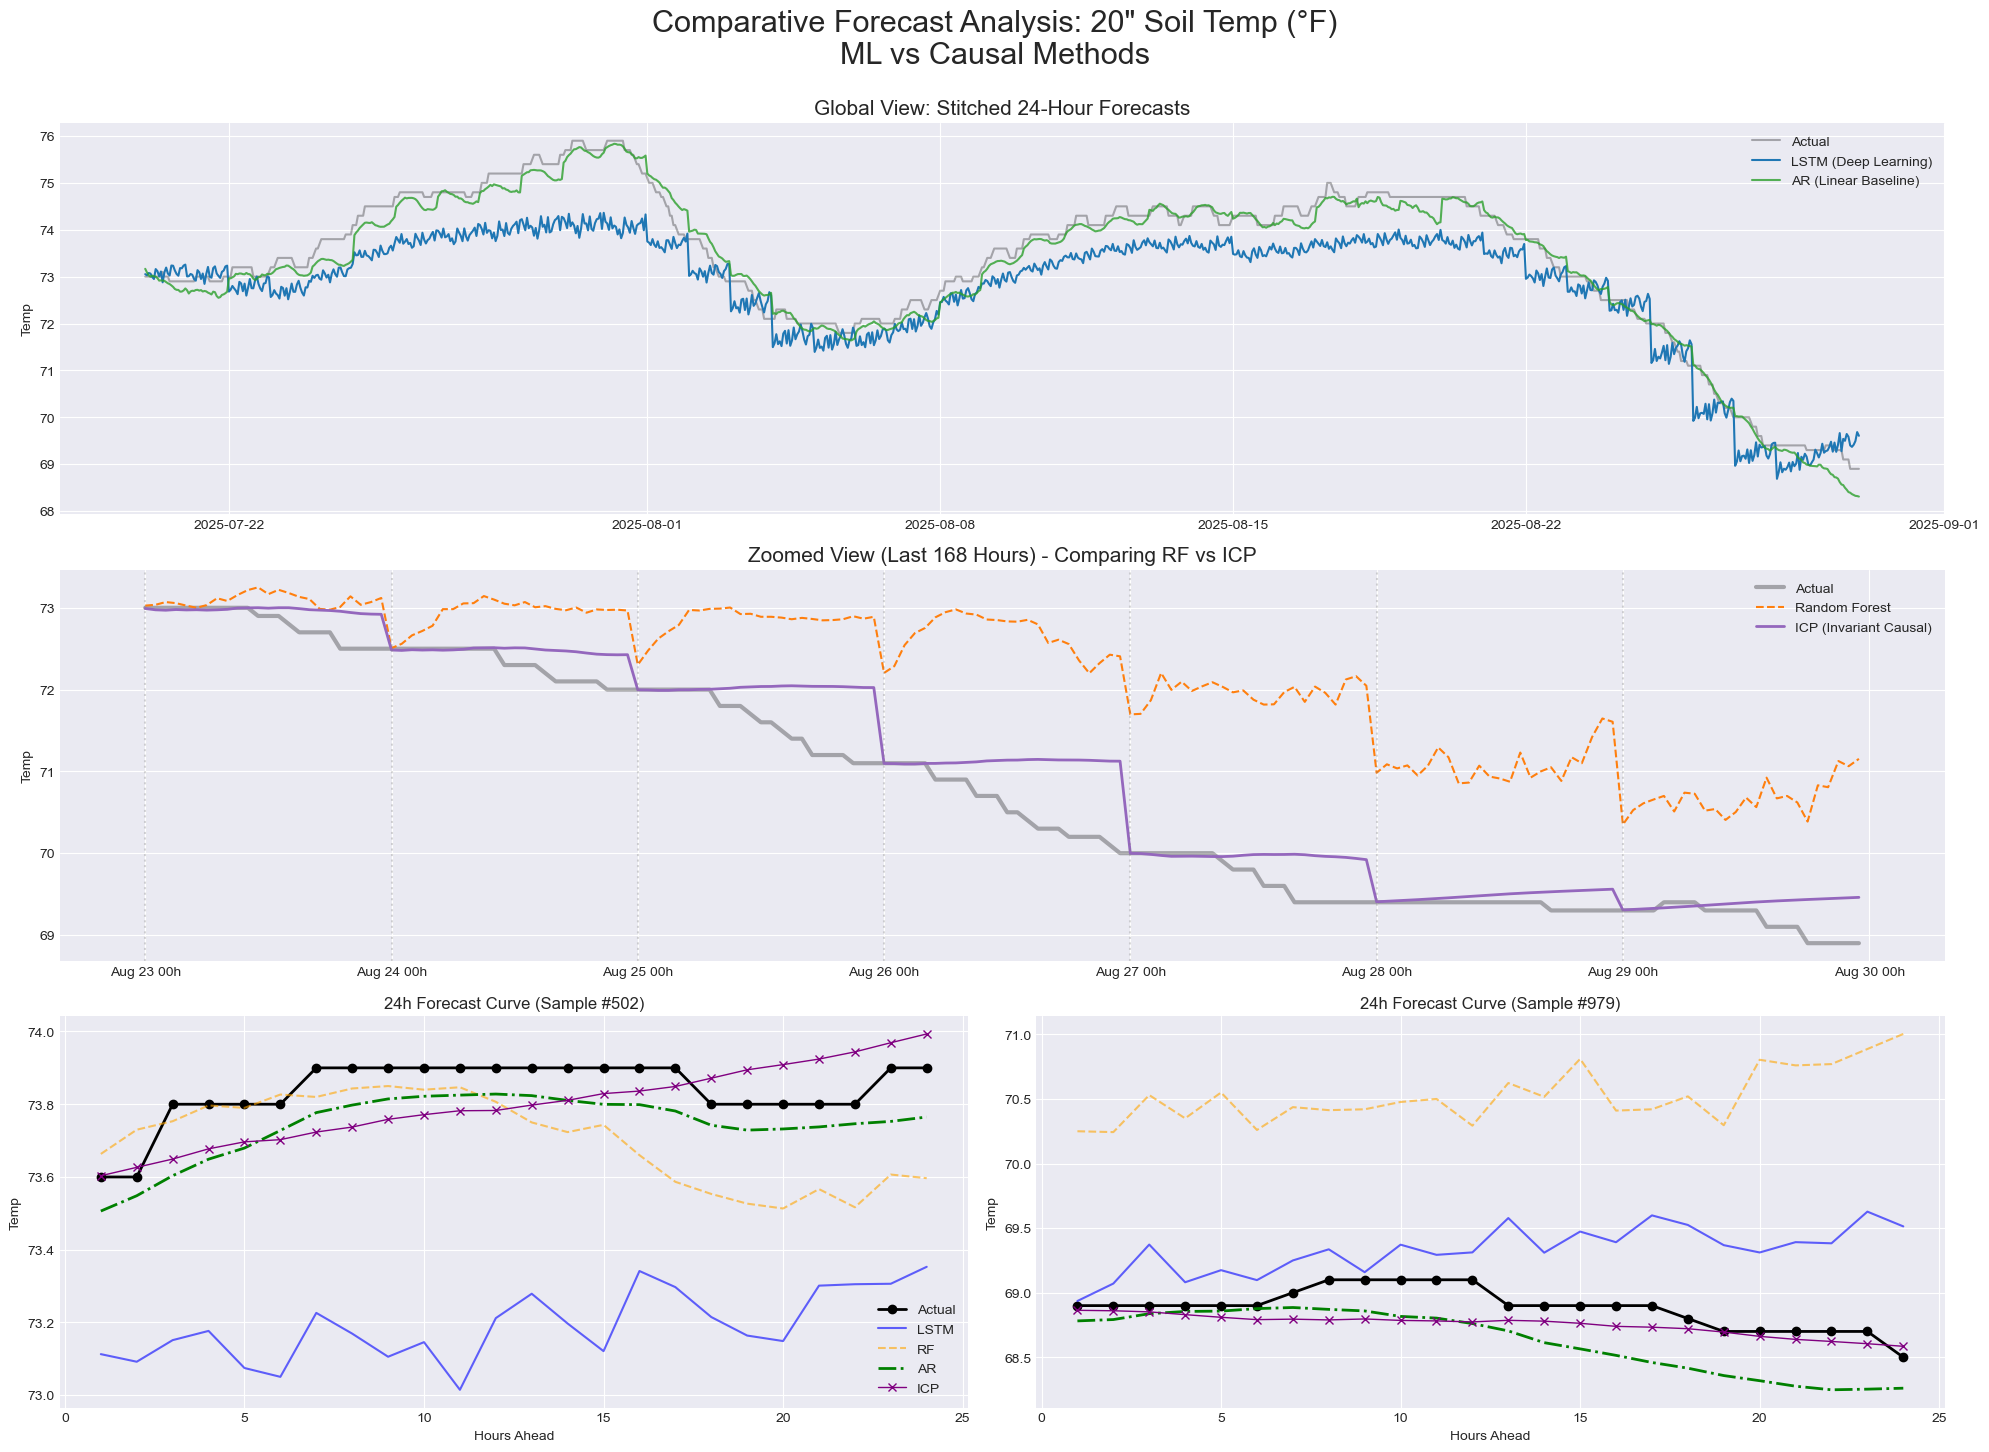

In [30]:
# ==========================================
# 6. VISUALIZATION
# ==========================================

full_dates = df.index[train_size + SEQ_LENGTH:]
stitched_dates, stitched_actual = [], []
stitched_lstm, stitched_rf, stitched_ar, stitched_icp = [], [], [], []

# Stitch forecasts (Jump by 24h)
for i in range(0, len(real_y_test), FORECAST_HORIZON):
    if i + FORECAST_HORIZON > len(real_y_test): break
        
    chunk_dates = full_dates[i : i + FORECAST_HORIZON]
    stitched_dates.extend(chunk_dates)
    stitched_actual.extend(real_y_test[i])
    stitched_lstm.extend(real_lstm_preds[i])
    stitched_rf.extend(real_rf_preds[i])
    stitched_ar.extend(real_ar_preds[i])
    stitched_icp.extend(real_icp_preds[i])

results_df = pd.DataFrame({
    'Time': stitched_dates,
    'Actual': stitched_actual,
    'LSTM': stitched_lstm,
    'RF': stitched_rf,
    'AR (Causal)': stitched_ar,
    'ICP': stitched_icp
}).set_index('Time')

plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(20, 20))
plt.suptitle(f'Comparative Forecast Analysis: {TARGET_COL}\nML vs Causal Methods', fontsize=22, y=0.96)

# --- PLOT 1: Full Stitched Series ---
ax1 = plt.subplot(4, 1, 1)
ax1.plot(results_df.index, results_df['Actual'], color='black', alpha=0.3, label='Actual')
ax1.plot(results_df.index, results_df['LSTM'], color='#1f77b4', linewidth=1.5, label='LSTM (Deep Learning)')
ax1.plot(results_df.index, results_df['AR (Causal)'], color='#2ca02c', linewidth=1.5, alpha=0.8, label='AR (Linear Baseline)')
ax1.set_title('Global View: Stitched 24-Hour Forecasts', fontsize=15)
ax1.legend(loc='upper right')
ax1.set_ylabel('Temp')

# --- PLOT 2: Zoomed View ---
ax2 = plt.subplot(4, 1, 2)
zoom_len = 168 # 1 Week
if len(results_df) > zoom_len: zoom_df = results_df.iloc[-zoom_len:]
else: zoom_df = results_df

ax2.plot(zoom_df.index, zoom_df['Actual'], 'k-', alpha=0.3, linewidth=3, label='Actual')
ax2.plot(zoom_df.index, zoom_df['RF'], color='#ff7f0e', linestyle='--', label='Random Forest')
ax2.plot(zoom_df.index, zoom_df['ICP'], color='#9467bd', linewidth=2, label='ICP (Invariant Causal)')

# Draw vertical lines for forecast updates
seam_dates = zoom_df.index[::24]
for d in seam_dates: ax2.axvline(d, color='gray', linestyle=':', alpha=0.3)
    
ax2.set_title(f'Zoomed View (Last {zoom_len} Hours) - Comparing RF vs ICP', fontsize=15)
ax2.legend()
ax2.set_ylabel('Temp')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Hh'))

# --- PLOT 3 & 4: Snapshots ---
indices = [len(real_y_test)//2, len(real_y_test)-25] 
hours_range = range(1, 25)

for i, idx in enumerate(indices):
    ax = plt.subplot(4, 2, 5 + i)
    
    ax.plot(hours_range, real_y_test[idx], 'k-o', label='Actual', linewidth=2)
    ax.plot(hours_range, real_lstm_preds[idx], 'b-', label='LSTM', alpha=0.6)
    ax.plot(hours_range, real_rf_preds[idx], 'orange', linestyle='--', label='RF', alpha=0.6)
    ax.plot(hours_range, real_ar_preds[idx], 'g-.', label='AR', linewidth=2)
    ax.plot(hours_range, real_icp_preds[idx], 'purple', marker='x', label='ICP', linewidth=1)
    
    ax.set_title(f'24h Forecast Curve (Sample #{idx})')
    ax.set_xlabel('Hours Ahead')
    ax.set_ylabel('Temp')
    if i == 0: ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()